# Pyrenew demo
This demo simulates some basic renewal process data and then fits to it using `pyrenew`.

You'll need to install `pyrenew` first. You'll also need working installations of `matplotlib`, `numpy`, `jax`, `numpyro`, and `polars`

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.size"] = 10
mpl.rcParams["axes.formatter.use_mathtext"] = True
mpl.rcParams["axes.grid"] = True
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.left"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.bottom"] = False
mpl.rcParams["legend.fancybox"] = True
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["legend.framealpha"] = 1

import jax
import jax.numpy as jnp
import numpy as np
from numpyro.handlers import seed
import numpyro.distributions as dist

/home/xrd4/.cache/pypoetry/virtualenvs/pyrenew-e8bt3r2y-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


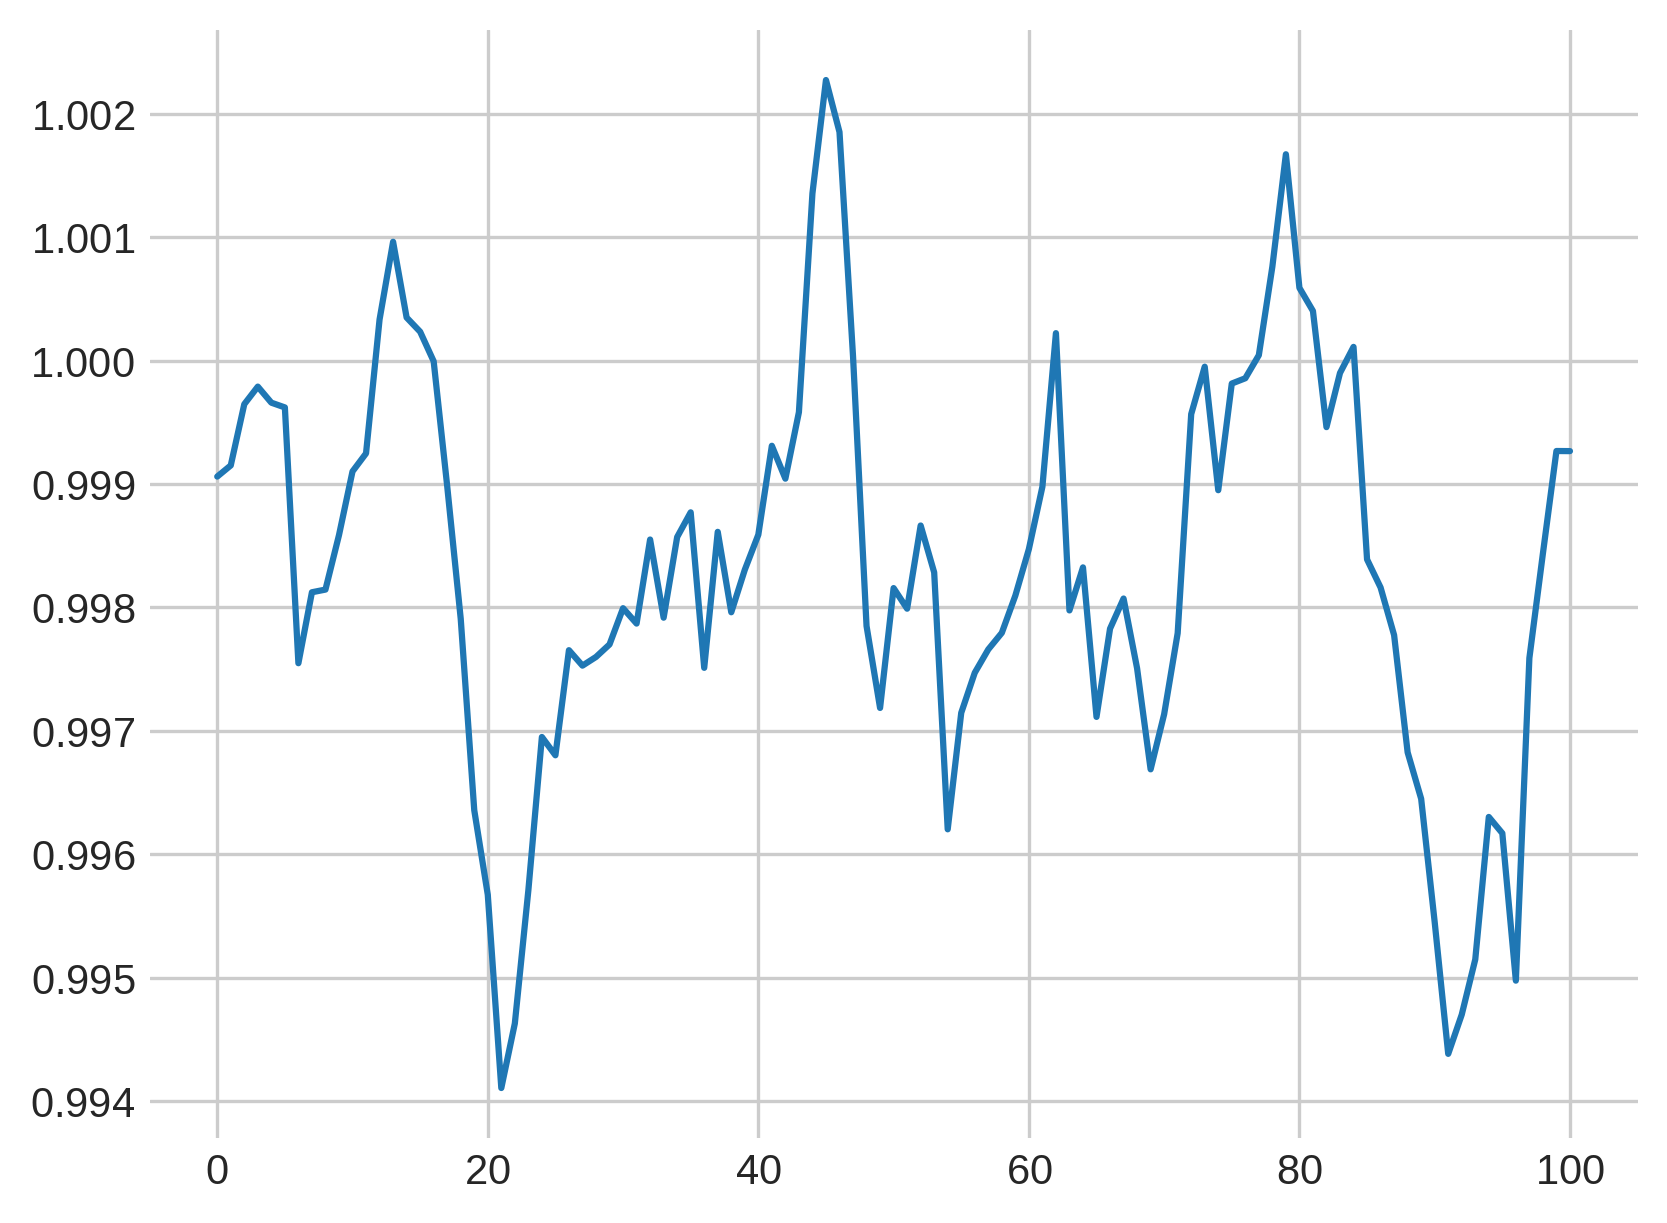

In [4]:
from pyrenew.processes import SimpleRandomWalkProcess

q = SimpleRandomWalkProcess(dist.Normal(0, 0.001))
with seed(rng_seed=np.random.randint(0,1000)):
    q_samp = q.sample(duration=100)
    
plt.plot(np.exp(q_samp))

In [5]:
from pyrenew.observations import (
    InfectionsObservation,
    HospitalizationsObservation,
)

from pyrenew.models import HospitalizationsModel
from pyrenew.processes import RtRandomWalkProcess

# Initializing model parameters
infections_obs = InfectionsObservation(jnp.array([0.25, 0.25, 0.25, 0.25]))
Rt_process = RtRandomWalkProcess()
hospitalizations_obs = HospitalizationsObservation(
    inf_hosp_int=jnp.array(
        [0, 0, 0,0,0,0,0,0,0,0,0,0,0, 0.25, 0.5, 0.1, 0.1, 0.05]
        )
    )

# Initializing the model
a = HospitalizationsModel(
    Rt_process           = Rt_process,
    infections_obs       = infections_obs,
    hospitalizations_obs = hospitalizations_obs,
    )

import numpyro
with numpyro.handlers.seed(rng_seed=6):
    b = a.hosp_observation_model.sample("test", np.array([1000,2,3]))
b

Array([981,   1,   2], dtype=int32)

In [6]:
with seed(rng_seed=np.random.randint(1, 60)):
    x = a.model(data=dict(n_timepoints=30))
x

(Array([0.9761383 , 0.97414154, 0.9637227 , 1.0077858 , 1.0188167 ,
        1.0231509 , 1.0292107 , 1.0300801 , 1.0567983 , 1.0471867 ,
        1.0674499 , 1.0212649 , 1.0248238 , 1.0193776 , 1.012263  ,
        1.0408006 , 1.0578802 , 1.0498741 , 1.034798  , 1.0302815 ,
        1.0267121 , 1.0733973 , 1.1280166 , 1.0982367 , 1.0900751 ,
        1.050785  , 1.0773097 , 1.1290584 , 1.1225555 , 1.1104715 ,
        1.124988  ], dtype=float32),
 Array([1.6085988, 1.9970591, 2.4568524, 3.1881793, 2.3561893, 2.5574372,
        2.716771 , 2.786    , 2.752008 , 2.8306022, 2.9582722, 2.8919368,
        2.9291563, 2.958735 , 2.970511 , 3.05744  , 3.1513832, 3.185861 ,
        3.1988702, 3.2437265, 3.2803042, 3.4640574, 3.718777 , 3.7633455,
        3.8769841, 3.8939893, 4.108077 , 4.4152946, 4.572827 , 4.71678  ,
        5.0098467], dtype=float32),
 Array(0.04792921, dtype=float32),
 Array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

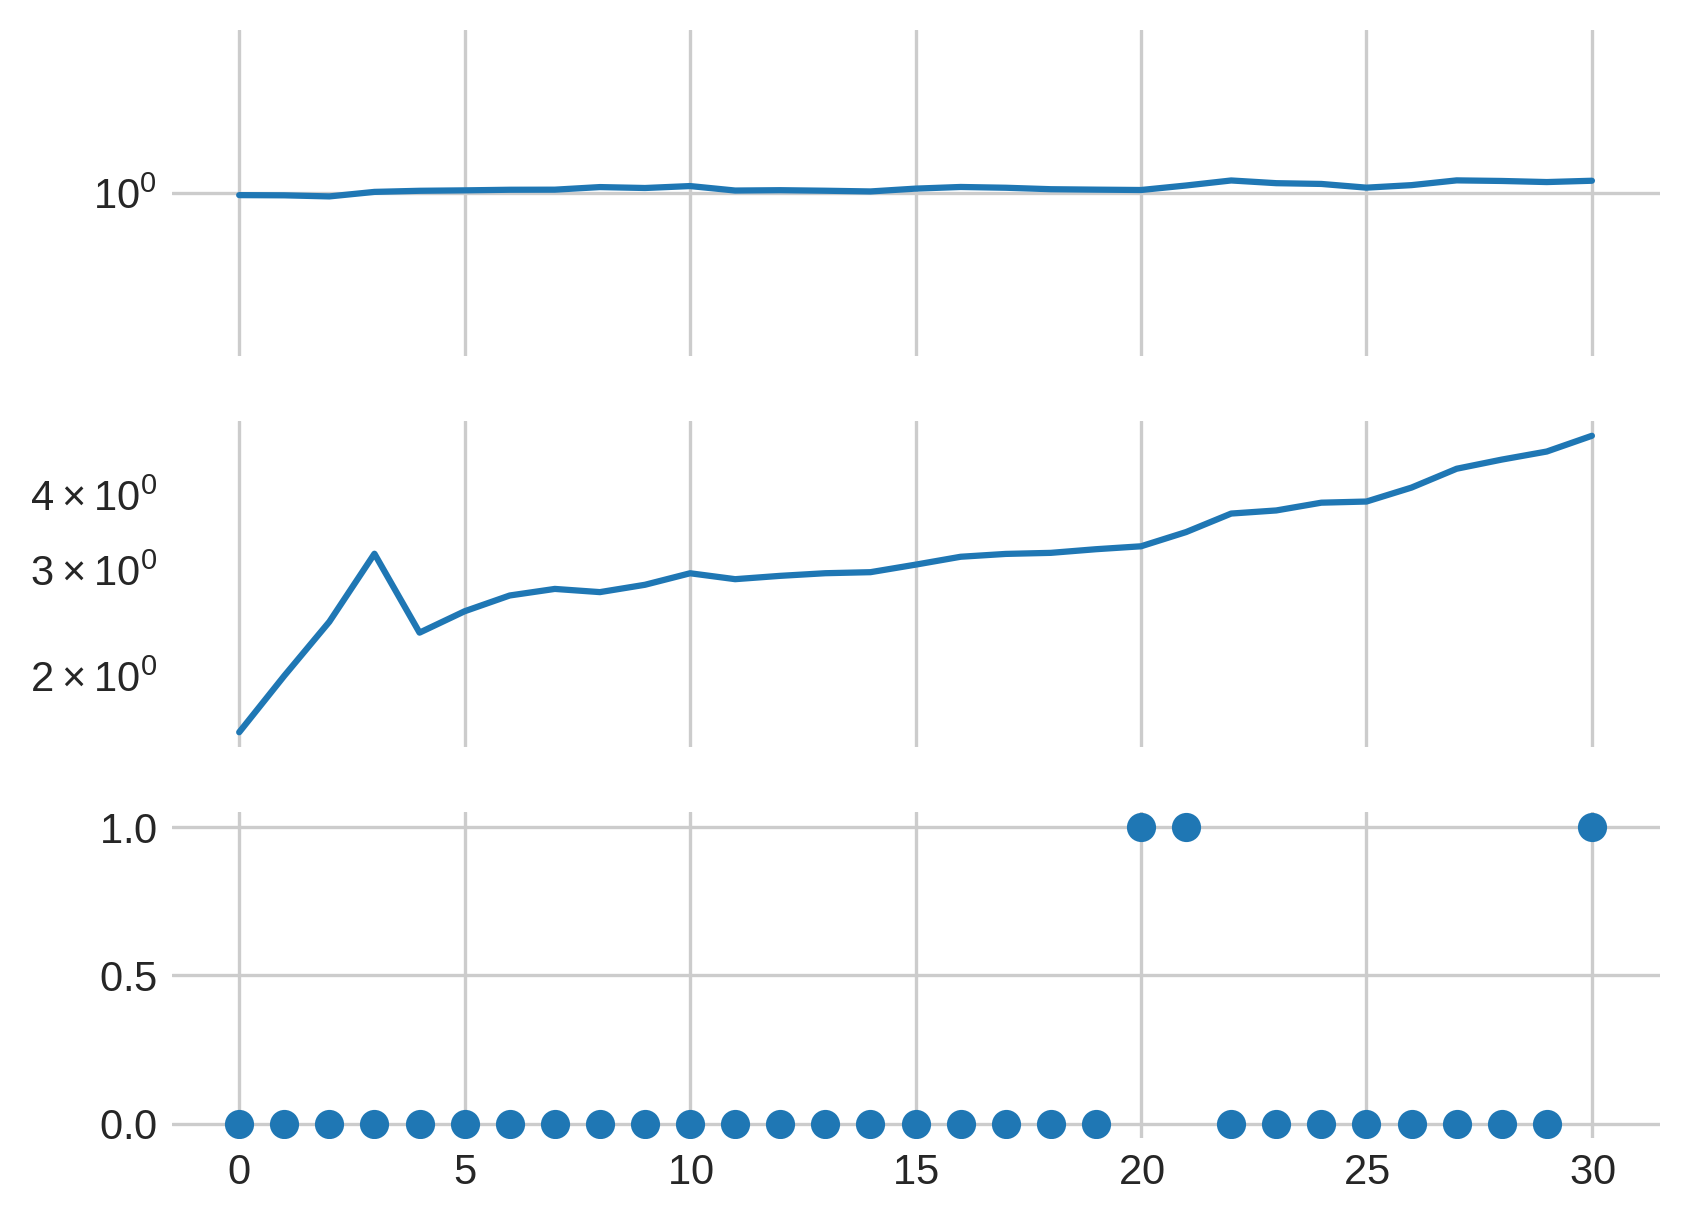

In [7]:
fig, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(x[0])
ax[0].set_ylim([1/5, 5])
ax[1].plot(x[1])
ax[2].plot(x[4], 'o')
for axis in ax[:-1]:
    axis.set_yscale("log")

In [8]:
sim_dat={"observed_hospitalizations": x[4],
         "n_timepoints":len(x[4])-1}
sim_dat["observed_hospitalizations"].shape

# from numpyro.infer import MCMC, NUTS
a.run(
    num_warmup=1000,
    num_samples=1000,
    data=sim_dat,
    rng_key=jax.random.PRNGKey(54),
    )

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1244.77it/s, 7 steps of size 4.48e-01. acc. prob=0.91] 


In [13]:
x

(Array([0.9761383 , 0.97414154, 0.9637227 , 1.0077858 , 1.0188167 ,
        1.0231509 , 1.0292107 , 1.0300801 , 1.0567983 , 1.0471867 ,
        1.0674499 , 1.0212649 , 1.0248238 , 1.0193776 , 1.012263  ,
        1.0408006 , 1.0578802 , 1.0498741 , 1.034798  , 1.0302815 ,
        1.0267121 , 1.0733973 , 1.1280166 , 1.0982367 , 1.0900751 ,
        1.050785  , 1.0773097 , 1.1290584 , 1.1225555 , 1.1104715 ,
        1.124988  ], dtype=float32),
 Array([1.6085988, 1.9970591, 2.4568524, 3.1881793, 2.3561893, 2.5574372,
        2.716771 , 2.786    , 2.752008 , 2.8306022, 2.9582722, 2.8919368,
        2.9291563, 2.958735 , 2.970511 , 3.05744  , 3.1513832, 3.185861 ,
        3.1988702, 3.2437265, 3.2803042, 3.4640574, 3.718777 , 3.7633455,
        3.8769841, 3.8939893, 4.108077 , 4.4152946, 4.572827 , 4.71678  ,
        5.0098467], dtype=float32),
 Array(0.04792921, dtype=float32),
 Array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

In [7]:
a.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
                         I0      9.48      2.06      9.26      6.28     12.57   1772.44      1.00
                        IHR      0.05      0.00      0.05      0.05      0.05   1358.65      1.00
                        Rt0      1.63      0.10      1.63      1.47      1.80   1105.50      1.00
 Rt_transformed_rw_diffs[0]      0.01      0.03      0.01     -0.03      0.05   1450.69      1.00
 Rt_transformed_rw_diffs[1]      0.01      0.02      0.01     -0.03      0.05   1265.48      1.00
 Rt_transformed_rw_diffs[2]      0.01      0.02      0.01     -0.03      0.05   1676.91      1.00
 Rt_transformed_rw_diffs[3]      0.01      0.02      0.01     -0.04      0.04   2231.18      1.00
 Rt_transformed_rw_diffs[4]      0.01      0.02      0.01     -0.03      0.05   1422.41      1.00
 Rt_transformed_rw_diffs[5]      0.01      0.03      0.01     -0.03      0.04   1451.77      1.00
 Rt_transformed_rw_

In [8]:
import polars as pl
import numpy as np

def spread_draws(posteriors, variable_names):
    """
    Given a dictionary of posteriors,
    return a long-form polars dataframe
    indexed by draw, with variable
    values (equivalent of tidybayes
    spread_draws() function).

    :param posteriors: a dictionary of posteriors
    with variable names as keys and numpy ndarrays
    as values (with the first axis corresponding
    to the posterior draw number.
    :param variable_names: list of strings or
    of tuples identifying which variables to
    retrieve.
    """

    for i_var, v in enumerate(variable_names):
        if isinstance(v, str):
            v_dims = None
        else:
            v_dims = v[1:]
            v = v[0]

        post = posteriors.get(v)
        long_post = post.flatten()[..., np.newaxis]

        indices = np.array(list(np.ndindex(post.shape)))
        n_dims = indices.shape[1] - 1
        if v_dims is None:
            dim_names = [("{}_dim_{}_index".format(v, k),
                          pl.Int64)
                         for k in range(n_dims)]
        elif len(v_dims) != n_dims:
            raise ValueError("incorrect number of "
                             "dimension names "
                             "provided for variable "
                             "{}".format(v))
        else:
            dim_names = [(v_dim, pl.Int64)
                         for v_dim in v_dims]

        p_df = pl.DataFrame(
            np.concatenate(
                [indices, long_post],
                axis=1
            ),
            schema=(
                [("draw", pl.Int64)] +
                dim_names +
                [(v, pl.Float64)])
        )

        if i_var == 0:
            df = p_df
        else:
            df = df.join(p_df,
                         on=[col for col in df.columns
                             if col in p_df.columns])
        pass

    return df


def spread_and_recover_ids(
        posteriors: dict,
        variable_names: list | tuple | str,
        id_mappers: dict = {},
        id_datatype: str = "str",
        keep_internal: bool = False):

    temp_spread = spread_draws(
        posteriors,
        variable_names)

    new_cols = []

    for dim_name, mapper in id_mappers.items():
        if dim_name in temp_spread.columns:
            map_vals = temp_spread.get_column(dim_name).to_numpy()
            new_cols.append(
                pl.lit(
                    mapper[map_vals].astype(id_datatype)
                ).alias(
                    dim_name
                )
            )

            if keep_internal:
                new_cols.append(
                    temp_spread.get_column(
                        dim_name
                    ).alias(
                        dim_name + "_internal"
                    ))

    return temp_spread.with_columns(
        new_cols)

In [9]:
samps = spread_draws(a.mcmc.get_samples(), [("Rt", "time")])

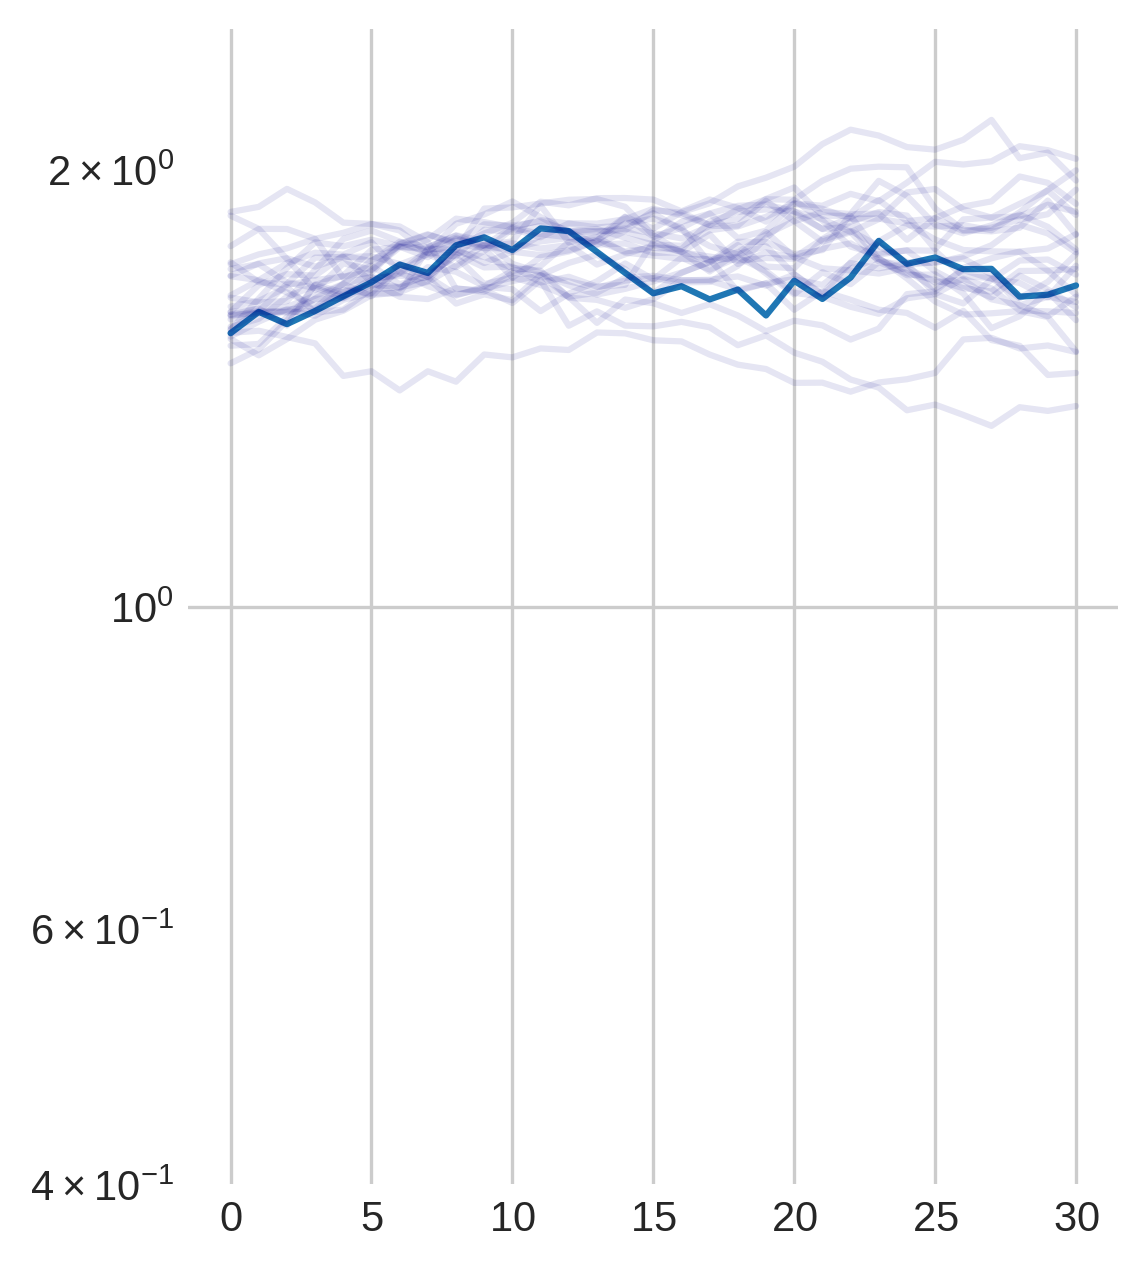

In [10]:
import numpy as np
import polars as pl
fig, ax = plt.subplots(figsize=[4, 5])

ax.plot(x[0])
samp_ids = np.random.randint(size=25, low=0, high=999)
for samp_id in samp_ids:
    sub_samps = samps.filter(pl.col("draw") == samp_id).sort(pl.col('time'))
    ax.plot(sub_samps.select("time").to_numpy(), 
            sub_samps.select("Rt").to_numpy(), color="darkblue", alpha=0.1)
ax.set_ylim([0.4, 1/.4])
ax.set_yticks([0.5, 1, 2])
ax.set_yscale("log")
